
# 🔹 What is Bucketing?

Think of **bucketing** as a **pre-shuffled grouping of data inside files**.

* **Partitioning** → splits **data into folders** based on column values (physical separation).
* **Bucketing** → splits **data into fixed number of files (buckets)** inside a table/folder, based on **hash of a column**.
* Buckets help **join and aggregate operations faster**, especially on large datasets.

📌 Analogy:

* Partitioning: Different drawers for each year
* Bucketing: Each drawer has numbered files → data is distributed evenly

---

# 🔹 How it Works in PySpark

* Spark creates **N buckets (files)** for the table
* Rows are **hashed** on the bucket column → assigned to a bucket
* Inside each bucket, Spark can also sort by another column (`sortBy`)

---

# 🔹 Bucketing vs Partitioning

| Feature          | Partitioning                       | Bucketing                       |
| ---------------- | ---------------------------------- | ------------------------------- |
| Physical storage | Separate folders                   | Separate files in a folder      |
| Number of files  | Depends on data size per partition | Fixed number of buckets (files) |
| Best use         | Filtering (WHERE)                  | Joins, aggregations             |
| SQL equivalent   | N/A                                | Table clustering / hash buckets |

---

---

# 🔹 Key Points

| Feature               | Parquet Table | CSV/JSON                   |
| --------------------- | ------------- | -------------------------- |
| True Bucketing        | ✅ Yes         | ❌ No                       |
| Joins Optimization    | ✅ Yes         | ⚠️ Only manual repartition |
| Fixed number of files | ✅ Yes         | ✅ By repartition()         |
| Sorting inside bucket | ✅ Yes         | ❌ No                       |
| Metadata aware        | ✅ Yes         | ❌ No                       |

---

# 🔹 Layman Summary

1. **Bucketing splits data into N files based on hash(column)**
2. **Partitioning splits data into folders based on column value**
3. **Parquet supports full bucketing with table metadata** → optimized joins & aggregations
4. **CSV/JSON cannot do true bucketing**, but `repartition()` mimics the effect
5. Use bucketing **for large tables that are joined frequently**




In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# 1️⃣ Create Spark session
spark = SparkSession.builder \
    .appName("SimpleDataFrameExample") \
    .getOrCreate()

# 2️⃣ Define schema
schema = StructType([
    StructField("order_id", IntegerType(), True),
    StructField("customer", StringType(), True),
    StructField("region", StringType(), True),
    StructField("amount", IntegerType(), True),
    StructField("order_date", StringType(), True)
])

# 3️⃣ Create data
data = [
    (3, "Charlie", "US", 150, "2024-01-03"),
    (1, "Alice", "US", 100, "2024-01-01"),
    (2, "Bob", "EU", 200, "2024-01-02")
]

# 4️⃣ Create DataFrame
df = spark.createDataFrame(data, schema)

# 5️⃣ Show the DataFrame
df.show()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/16 19:33:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/16 19:33:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/16 19:33:59 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/16 19:33:59 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
26/01/16 19:33:59 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
26/01/16 19:33:59 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
                                                                                

+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       3| Charlie|    US|   150|2024-01-03|
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+



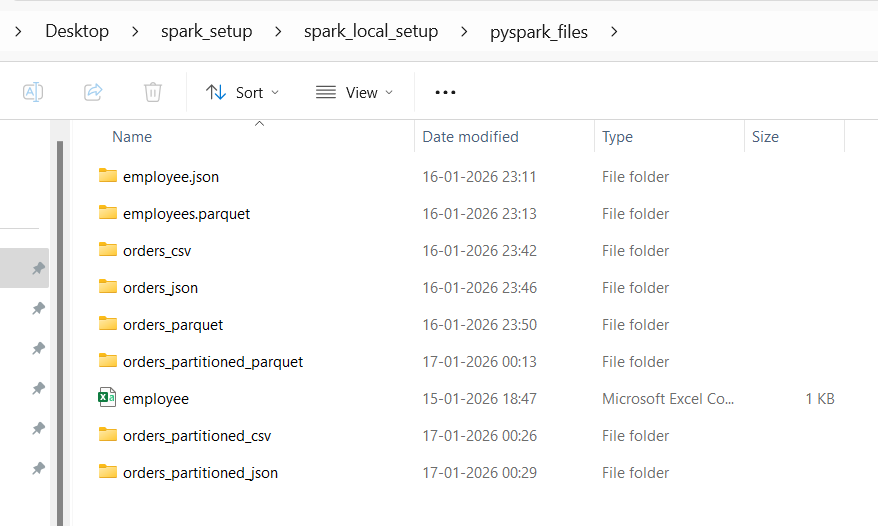


In [4]:
df.write \
  .bucketBy(3, "region") \   # 3 buckets based on 'region'
  .sortBy("order_id") \      # optional, sorts data inside buckets
  .mode("overwrite") \
  .saveAsTable("/data/orders_bucketed_parquet")

SyntaxError: unexpected character after line continuation character (2677252620.py, line 2)

In [14]:
df.write \
  .bucketBy(3, "region") \
  .sortBy("order_id") \
  .mode("overwrite") \
  .saveAsTable("orders_bucketed_parquet")



In [15]:
spark.table("orders_bucketed_parquet").show()


+--------+--------+------+------+----------+
|order_id|customer|region|amount|order_date|
+--------+--------+------+------+----------+
|       3| Charlie|    US|   150|2024-01-03|
|       1|   Alice|    US|   100|2024-01-01|
|       2|     Bob|    EU|   200|2024-01-02|
+--------+--------+------+------+----------+




## 📍 Where is bucketed data created locally?

### 🔹 **Short answer**

When you use:

```python
df.write.bucketBy(...).saveAsTable("orders_bucketed_parquet")
```

👉 **Buckets are NOT created as folders like partitions**
👉 They are created as **files inside the table directory**

---

## 📂 PartitionBy vs BucketBy (physical layout)

### 🔹 Partitioned data (`partitionBy`)

```python
df.write.partitionBy("order_date").parquet("/data/orders_partitioned")
```

**Physical layout**

```
/data/orders_partitioned/
 ├── order_date=2024-01-01/
 │    ├── part-0000.parquet
 ├── order_date=2024-01-02/
 │    ├── part-0001.parquet
```

➡ Folder names = partition column values
➡ Easy to see and filter at filesystem level

---

### 🔹 Bucketed data (`bucketBy`)

```python
df.write.bucketBy(3, "region").saveAsTable("orders_bucketed_parquet")
```

**Physical layout**

```
spark-warehouse/
 └── orders_bucketed_parquet/
      ├── part-00000-xxxx.snappy.parquet
      ├── part-00001-xxxx.snappy.parquet
      ├── part-00002-xxxx.snappy.parquet
```

➡ **No `region=US` folders**
➡ Buckets are **logical**, not directory-based
➡ Bucket number is encoded in file names

---

## 📍 Where exactly is `spark-warehouse`?

Run:

```python
spark.conf.get("spark.sql.warehouse.dir")
```

Typical local default:

```
/user/hive/warehouse
```

or

```
file:/.../spark-warehouse
```

Example full path:

```
/home/user/spark-warehouse/orders_bucketed_parquet/
```

---

## 🔎 How Spark knows bucket info

Bucketing metadata is stored in the **table catalog**, not the filesystem:

```python
spark.sql("DESCRIBE EXTENDED orders_bucketed_parquet").show(truncate=False)
```

You’ll see:

```
Num Buckets: 3
Bucket Columns: [region]
Sort Columns: [order_id]
```

➡ Spark uses this metadata at **query time**, not folder structure.

---

## 🧠 Why bucketing doesn’t create folders

| Reason           | Explanation                           |
| ---------------- | ------------------------------------- |
| Fixed buckets    | Buckets must be consistent for joins  |
| Hash-based       | region → hash → bucket number         |
| Optimizer-driven | Used internally for shuffle avoidance |

Folders would break these guarantees.

---

## 🚨 Important production note

If you delete or move files manually:

* ❌ Bucketing metadata still exists
* ❌ Spark may produce wrong results or fall back to shuffle

Always manage bucketed tables via Spark SQL.

---

## ✅ Summary

| Feature               | PartitionBy | BucketBy |
| --------------------- | ----------- | -------- |
| Creates folders       | ✅ Yes       | ❌ No     |
| Visible in filesystem | ✅ Very      | ❌ Hidden |
| Used for filtering    | ✅ Yes       | ❌ No     |
| Used for joins        | ❌ No        | ✅ Yes    |
| Stored in catalog     | ❌ No        | ✅ Yes    |



In [16]:
spark.conf.get("spark.sql.warehouse.dir")

'file:/opt/spark-notebooks/spark-warehouse'

In [17]:
spark.sql("DESCRIBE EXTENDED orders_bucketed_parquet").show(truncate=False)


+----------------------------+-----------------------------------------------------------------+-------+
|col_name                    |data_type                                                        |comment|
+----------------------------+-----------------------------------------------------------------+-------+
|order_id                    |int                                                              |NULL   |
|customer                    |string                                                           |NULL   |
|region                      |string                                                           |NULL   |
|amount                      |int                                                              |NULL   |
|order_date                  |string                                                           |NULL   |
|                            |                                                                 |       |
|# Detailed Table Information|                         

BBucketing for CSV & JSON

Spark does not natively support bucketing for raw CSV/JSON files

You can repartition by a column → creates N files → similar effect to bucketing

Creates 3 files distributed by region hash

But not a formal bucketed table → no Spark-aware metadata → less efficient

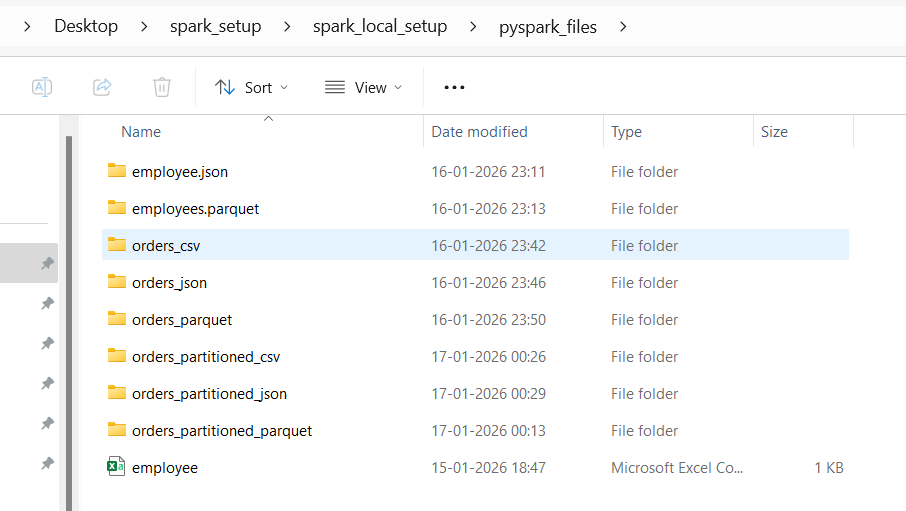

In [18]:
# Approximate bucketing for CSV/JSON
df.repartition(3, "region") \
  .write \
  .mode("overwrite") \
  .option("header", "true") \
  .csv("/data/orders_csv_bucketed")

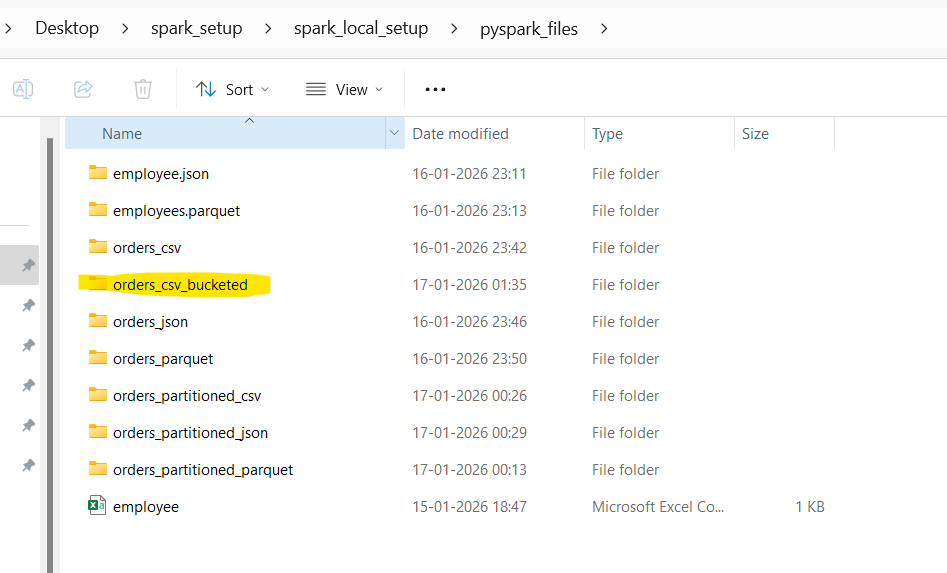


## Why **NO bucketing** for CSV & JSON?

### In simple words

**Bucketing needs files that can store “extra intelligence”** (metadata + structure).
CSV and JSON are **just plain text**, so Spark can’t reliably do that.

---

## CSV / JSON (Plain text formats)

* ❌ No schema stored inside files
* ❌ No metadata support (bucket info, sort info)
* ❌ Row-by-row text parsing (slow)
* ❌ Spark cannot guarantee:

  * same rows → same bucket
  * stable hashing across writes
* ❌ Bucketing metadata would be **lost**

👉 So Spark **does NOT allow bucketing** for CSV/JSON.

---

## Parquet (Columnar format)

* ✅ Schema stored inside files
* ✅ Supports table metadata
* ✅ Column-based storage (fast)
* ✅ Stable hashing + sorting
* ✅ Bucketing metadata stored in **catalog**

👉 Spark **can safely use bucketing** with Parquet.

---

## 🧠 Layman analogy

| Format     | Think of it as                   |
| ---------- | -------------------------------- |
| CSV / JSON | Notebook pages with raw text     |
| Parquet    | Smart filing cabinet with labels |

You can’t organize (bucket) loose pages reliably — but you **can** with a cabinet.

---

## 📊 Quick comparison table

| Feature           | CSV / JSON | Parquet |
| ----------------- | ---------- | ------- |
| Text or binary    | Text       | Binary  |
| Schema stored     | ❌ No       | ✅ Yes   |
| Metadata support  | ❌ No       | ✅ Yes   |
| Columnar          | ❌ No       | ✅ Yes   |
| Bucketing allowed | ❌ No       | ✅ Yes   |
| Fast joins        | ❌ No       | ✅ Yes   |

---

## ⭐ One-line interview answer

> **Bucketing needs schema and metadata consistency, which CSV/JSON lack. Parquet supports both, so Spark allows bucketing only with Parquet.**





This is a **very good, real–world big-data design question**. I’ll explain it **as it is done in production** for **very large (5+ TB) tables**, using **Employee** and **Order** tables, and I’ll be very clear about **why**, **when**, and **how** we choose **partitioning vs bucketing vs both**.

I’ll avoid buzzwords and explain the **decision logic**.

---

# 🔹 Scenario Setup (Very Large Data)

Assume **each table > 5 TB**

## Employee Table (emp)

| emp_id | name  | dept_id | country | join_date  |
| ------ | ----- | ------- | ------- | ---------- |
| 101    | Alice | 10      | US      | 2019-01-01 |
| 102    | Bob   | 20      | IN      | 2020-03-15 |
| …      | …     | …       | …       | …          |

## Orders Table (orders)

| order_id | emp_id | amount | region | order_date |
| -------- | ------ | ------ | ------ | ---------- |
| 5001     | 101    | 300    | US     | 2024-01-01 |
| 5002     | 102    | 500    | IN     | 2024-01-02 |
| …        | …      | …      | …      | …          |

---

# 1️⃣ FIRST QUESTION: Why partition or bucket at all?

Because:

* Tables are **huge (5+ TB)**
* Reading everything every time = **slow + expensive**
* Joins cause **massive shuffle** unless optimized

So we ask **two key questions**:

---

# 2️⃣ Decision Rule (Very Important)

## 🔑 PartitionBy → used for **FILTERING**

## 🔑 BucketBy → used for **JOINS / AGGREGATIONS**

👉 They solve **different problems**

---

# 3️⃣ How to Choose PARTITION column (Golden Rules)

Choose a column that:

1. Is **frequently used in WHERE filters**
2. Has **limited but not tiny cardinality**
3. Is **stable** (won’t change)

❌ Bad partition columns:

* emp_id (millions of folders ❌)
* order_id (too many ❌)

✅ Good partition columns:

* order_date
* country
* region
* join_year

---

# 4️⃣ How to Choose BUCKET column (Golden Rules)

Choose a column that:

1. Is **frequently used in JOIN**
2. Has **high cardinality**
3. Is **evenly distributed**

✅ Good bucket columns:

* emp_id
* dept_id

❌ Bad bucket columns:

* country (low cardinality)
* gender

---

# 5️⃣ Design for EMPLOYEE TABLE (5+ TB)

## 🔹 Typical Queries

* Filter employees by **country**
* Join with orders on **emp_id**

---

## ✅ Final Design: Employee Table

### Partition by country

### Bucket by emp_id

```python
emp_df.write \
  .partitionBy("country") \
  .bucketBy(200, "emp_id") \
  .sortBy("emp_id") \
  .mode("overwrite") \
  .saveAsTable("employee_tbl")
```

### Why this works:

* `country` → limits data scanned
* `emp_id` → join key → bucketing avoids shuffle
* 200 buckets → balances file size (~256MB per file)

---

## 📂 Physical Layout (Simplified)

```
employee_tbl/
  country=US/
     bucket_000.parquet
     bucket_001.parquet
  country=IN/
     bucket_000.parquet
     bucket_001.parquet
```

---

# 6️⃣ Design for ORDER TABLE (5+ TB)

## 🔹 Typical Queries

* Filter by **order_date**
* Join with employee on **emp_id**

---

## ✅ Final Design: Orders Table

### Partition by order_date

### Bucket by emp_id

```python
orders_df.write \
  .partitionBy("order_date") \
  .bucketBy(200, "emp_id") \
  .sortBy("emp_id") \
  .mode("overwrite") \
  .saveAsTable("orders_tbl")
```

---

# 7️⃣ What Happens During JOIN?

```sql
SELECT *
FROM orders_tbl o
JOIN employee_tbl e
ON o.emp_id = e.emp_id
WHERE o.order_date = '2024-01-01'
  AND e.country = 'US';
```

### Spark Execution (Optimized)

1. **Partition pruning**

   * Reads only:

     * `orders_tbl/order_date=2024-01-01`
     * `employee_tbl/country=US`

2. **Bucketed join**

   * emp_id hash matches
   * bucket 15 joins with bucket 15
   * ❌ No massive shuffle

🔥 Result:

* Reads **only few GB instead of 5 TB**
* Join is **much faster**

---

# 8️⃣ Are Buckets Used Only for Joins?

❌ **No**

### Bucketing is also useful for:

* `GROUP BY emp_id`
* `COUNT(emp_id)`
* `DISTINCT emp_id`
* Heavy aggregations

```sql
SELECT emp_id, SUM(amount)
FROM orders_tbl
GROUP BY emp_id;
```

Spark can aggregate **bucket-wise**.

---

# 9️⃣ When NOT to use Bucketing

❌ If table:

* Is small (<100 GB)
* Rarely joined
* Frequently updated (bucketing is static)

---

# 🔟 Can We Bucket Without Partitioning?

✅ Yes (join-only optimization)

```python
df.write \
  .bucketBy(200, "emp_id") \
  .saveAsTable("orders_bucketed_only")
```

Used when:

* Queries rarely filter
* Mostly full-table joins

---

# 1️⃣1️⃣ Can We Partition Without Bucketing?

✅ Yes (filter-only optimization)

```python
df.write \
  .partitionBy("order_date") \
  .parquet("/data/orders_partitioned_only")
```

Used when:

* No heavy joins
* Mostly filtering

---

# 1️⃣2️⃣ Why We Often Use BOTH for Big Tables

| Problem                  | Solved By    |
| ------------------------ | ------------ |
| Reduce data read         | Partitioning |
| Reduce shuffle           | Bucketing    |
| Faster joins             | Bucketing    |
| Faster filters           | Partitioning |
| Large table optimization | Both         |

---

# 🔚 FINAL BIG-DATA SUMMARY (Interview Gold)

> **Partitioning is for reducing data scanned.
> Bucketing is for reducing data shuffled.
> For 5+ TB tables used in joins, we usually use both.**

---

